# Spark Connection

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum as spark_sum, avg, count, when
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.clustering import KMeans as SparkKMeans
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns



In [2]:
spark = SparkSession.builder.appName("TerrorismDataAnalysisSpark").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/01/01 16:27:43 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
df_spark = spark.read.csv("globalterrorismdb.csv", header=True, inferSchema=True)


# Questions

## 1) Which group caused the highest avg casualties per attack over all years?



In [4]:
group_avg = df_spark.groupBy("gname") \
    .agg((spark_sum("nkill") / count("*")).alias("avg_kills")) \
    .filter(col("gname") != "Unknown") \
    .orderBy(col("avg_kills").desc()) \
    .limit(5)

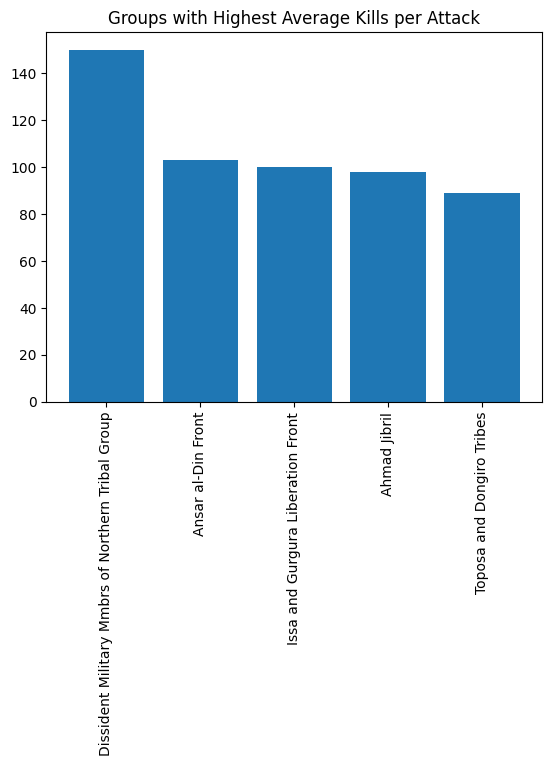

In [5]:
group_avg_pdf = group_avg.toPandas()
plt.figure()
plt.bar(group_avg_pdf["gname"], group_avg_pdf["avg_kills"])
plt.title("Groups with Highest Average Kills per Attack")
plt.xticks(rotation=90)
#plt.tight_layout()
plt.show()

In [6]:
group_avg_pdf.head(5)


,gname,avg_kills
0,Dissident Military Mmbrs of Northern Tribal Group,150.0
1,Ansar al-Din Front,103.0
2,Issa and Gurgura Liberation Front,100.0
3,Ahmad Jibril,98.0
4,Toposa and Dongiro Tribes,89.0


## 2) Which country had the highest number of total wounded?

In [7]:
country_wounded = df_spark.groupBy("country_txt") \
    .agg(spark_sum("nwound").alias("total_wounded")) \
    .orderBy(col("total_wounded").desc()) \
    .limit(5)

In [8]:
country_wounded_pdf = country_wounded.toPandas()

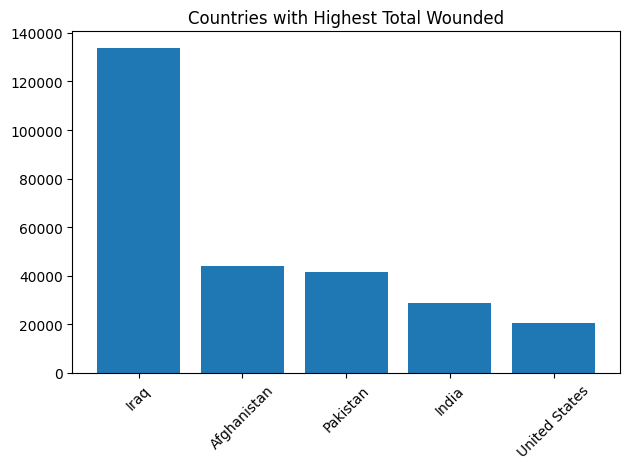

In [9]:
plt.figure()
plt.bar(country_wounded_pdf["country_txt"], country_wounded_pdf["total_wounded"])
plt.title("Countries with Highest Total Wounded")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [10]:
country_wounded_pdf.head()

,country_txt,total_wounded
0,Iraq,133954.0
1,Afghanistan,44218.0
2,Pakistan,41360.0
3,India,28841.0
4,United States,20606.0


## 3) Which region has the highest average wounded per attack?

In [11]:
region_avg_wounded = df_spark.groupBy("region_txt") \
    .agg((spark_sum("nwound") / count("*")).alias("avg_wounded")) \
    .filter(col("region_txt").isNotNull()) \
    .orderBy(col("avg_wounded").desc()) \
    .limit(5)
region_avg_wounded_pdf = region_avg_wounded.toPandas()

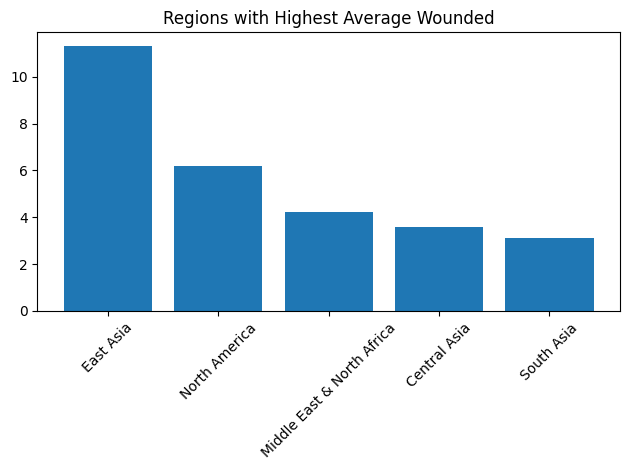

In [12]:
plt.figure()
plt.bar(region_avg_wounded_pdf["region_txt"], region_avg_wounded_pdf["avg_wounded"])
plt.title("Regions with Highest Average Wounded")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [13]:
region_avg_wounded_pdf.head(5)

,region_txt,avg_wounded
0,East Asia,11.329177
1,North America,6.201968
2,Middle East & North Africa,4.228236
3,Central Asia,3.568384
4,South Asia,3.119358


## 4) Which city has the highest total casualties (killed + wounded)?

In [14]:
city_casualties = df_spark.groupBy("city") \
    .agg((spark_sum("nkill") + spark_sum("nwound")).alias("total_casualties")) \
    .filter(col("city").isNotNull()) \
    .orderBy(col("total_casualties").desc()) \
    .limit(5)

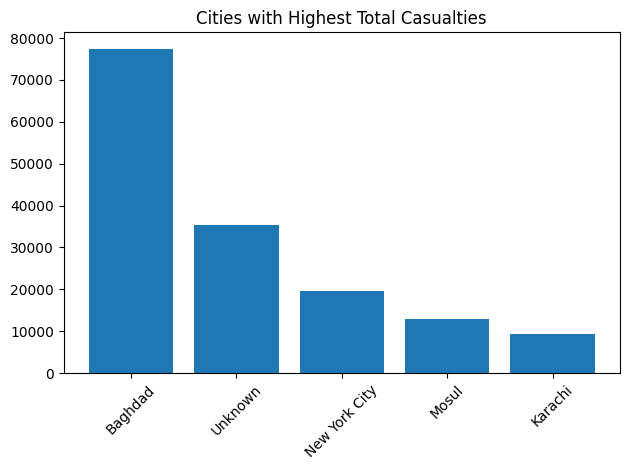

In [15]:
city_casualties_pdf = city_casualties.toPandas()
plt.figure()
plt.bar(city_casualties_pdf["city"], city_casualties_pdf["total_casualties"])
plt.title("Cities with Highest Total Casualties")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [16]:
city_casualties_pdf.head(5)

,city,total_casualties
0,Baghdad,77483.0
1,Unknown,35304.0
2,New York City,19583.0
3,Mosul,12889.0
4,Karachi,9355.0


## 5) Which group used chemical weapons the most?

In [17]:
chemical_weapons = df_spark.filter(col("weapdetail").like("%chemical%")) \
    .groupBy("gname") \
    .count() \
    .filter(col("gname") != "Unknown") \
    .orderBy(col("count").desc()) \
    .limit(5)

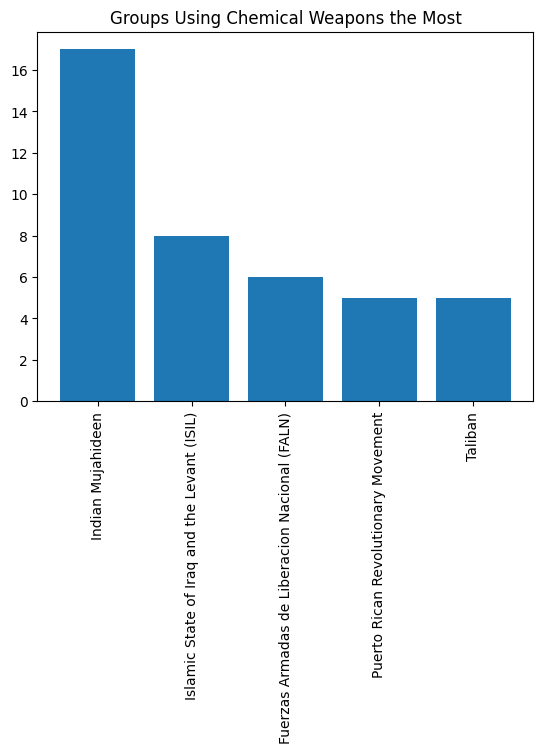

In [18]:
chemical_weapons_pdf = chemical_weapons.toPandas()
plt.figure()
plt.bar(chemical_weapons_pdf["gname"], chemical_weapons_pdf["count"])
plt.title("Groups Using Chemical Weapons the Most")
plt.xticks(rotation=90)
#plt.tight_layout()
plt.show()

In [19]:
chemical_weapons_pdf.head(5)


,gname,count
0,Indian Mujahideen,17
1,Islamic State of Iraq and the Levant (ISIL),8
2,Fuerzas Armadas de Liberacion Nacional (FALN),6
3,Puerto Rican Revolutionary Movement,5
4,Taliban,5


## 6) Which target type has the highest total kills?

In [20]:
target_kills = df_spark.groupBy("targtype1_txt") \
    .agg(spark_sum("nkill").alias("total_kills")) \
    .filter(col("targtype1_txt").isNotNull()) \
    .orderBy(col("total_kills").desc()) \
    .limit(5)

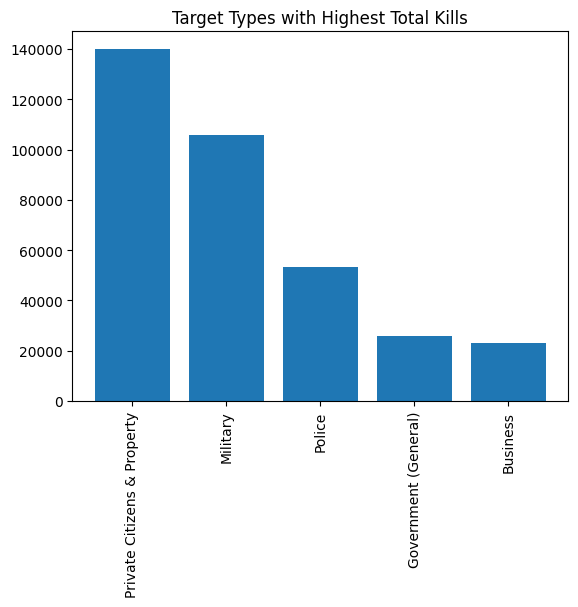

In [21]:
target_kills_pdf = target_kills.toPandas()
plt.figure()
plt.bar(target_kills_pdf["targtype1_txt"], target_kills_pdf["total_kills"])
plt.title("Target Types with Highest Total Kills")
plt.xticks(rotation=90)
#plt.tight_layout()
plt.show()

In [22]:
target_kills_pdf.head()

,targtype1_txt,total_kills
0,Private Citizens & Property,139988.0
1,Military,105689.0
2,Police,53361.0
3,Government (General),26025.0
4,Business,23201.0


In [23]:
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

selected_columns = ["iyear", "region", "attacktype1", "weaptype1", "nkill", "success"]
dataset = df_spark.select(selected_columns).dropna()
dataset = dataset.withColumn("nkill", col("nkill").cast("float"))
dataset = dataset.withColumn("success", col("success").cast("integer"))

dataset = dataset.dropna(subset=["nkill","success"])

majority_class = dataset.filter(col("success") == 1)
minority_class = dataset.filter(col("success") == 0)

minority_class_oversampled = minority_class.sample(withReplacement=True, fraction=2.0, seed=42)

test = minority_class.sample(withReplacement=True, fraction=3.0, seed=42)

ara = test.union(minority_class_oversampled)
dataset = majority_class.union(ara)
dataset = dataset.sample(withReplacement=False, fraction=1.0, seed=256)

indexers = [
    StringIndexer(inputCol=col, outputCol=f"{col}_index").fit(dataset)
    for col in ["region", "attacktype1", "weaptype1"]
]

for indexer in indexers:
    dataset = indexer.transform(dataset)


assembler = VectorAssembler(
    inputCols=["iyear", "region_index", "attacktype1_index", "weaptype1_index", "nkill"],
    outputCol="features"
)
dataset = assembler.transform(dataset).select("features", "success")

train_data, test_data = dataset.randomSplit([0.8, 0.2], seed=42)




In [24]:
dataset=dataset.sample(withReplacement=False, fraction=1.0, seed=42)

rf = RandomForestClassifier(featuresCol="features", labelCol="success", numTrees=100, maxDepth=10)
rf_model = rf.fit(train_data)
predictions = rf_model.transform(test_data)

evaluator = MulticlassClassificationEvaluator(
    labelCol="success", predictionCol="prediction", metricName="accuracy"
)
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy * 100:.2f}%")

25/01/01 16:28:01 WARN DAGScheduler: Broadcasting large task binary with size 1197.6 KiB
25/01/01 16:28:02 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/01/01 16:28:03 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
25/01/01 16:28:05 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB
25/01/01 16:28:08 WARN DAGScheduler: Broadcasting large task binary with size 1437.6 KiB
25/01/01 16:28:08 WARN DAGScheduler: Broadcasting large task binary with size 11.1 MiB
25/01/01 16:28:12 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/01/01 16:28:13 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
[Stage 56:=================================>                     (20 + 11) / 33]

Accuracy: 77.72%


25/01/01 16:28:15 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
                                                                                

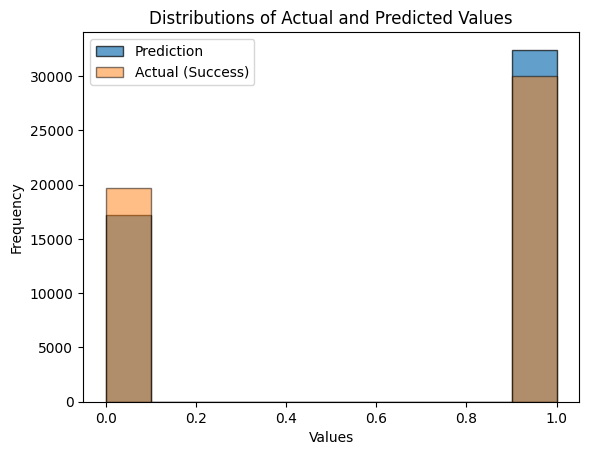

In [25]:
predictions_pd = predictions.select("success", "prediction").toPandas()
predictions_pd = predictions_pd.sample(frac=1, random_state=42).reset_index(drop=True)

# Distribution of predicted values
plt.hist(predictions_pd["prediction"], bins=10, edgecolor="k", alpha=0.7, label="Prediction")

# Distribution of actual values
plt.hist(predictions_pd["success"], bins=10, edgecolor="k", alpha=0.5, label="Actual (Success)")

# Plot details
plt.title("Distributions of Actual and Predicted Values")
plt.xlabel("Values")
plt.ylabel("Frequency")
plt.legend(loc="upper left")
plt.show()

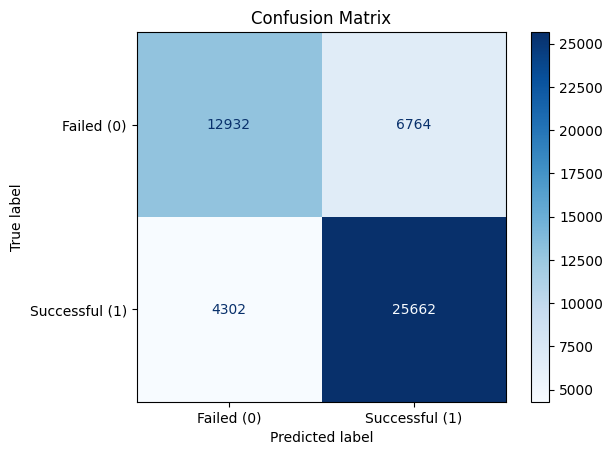

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get the true and predicted values
y_true = predictions_pd["success"]
y_pred = predictions_pd["prediction"]

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Failed (0)", "Successful (1)"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

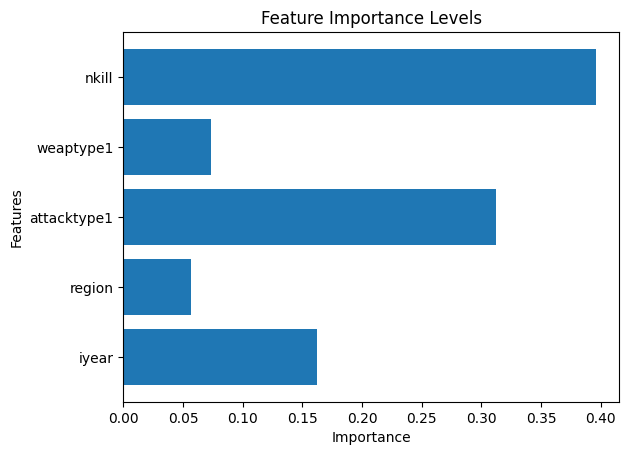

In [27]:
# Get feature importance levels
feature_importances = rf_model.featureImportances
features = ["iyear", "region", "attacktype1", "weaptype1", "nkill"]

# Visualize feature importance
plt.barh(features, feature_importances)
plt.title("Feature Importance Levels")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

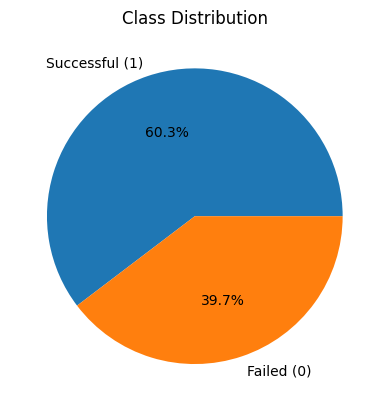

In [28]:
# Visualize the distribution of actual values
success_counts = predictions_pd["success"].value_counts()

# Pie chart
success_counts.plot.pie(autopct="%.1f%%", labels=["Successful (1)", "Failed (0)"])
plt.title("Class Distribution")
plt.ylabel("")
plt.show()

In [29]:
success_counts

success
1    29964
0    19696
Name: count, dtype: int64

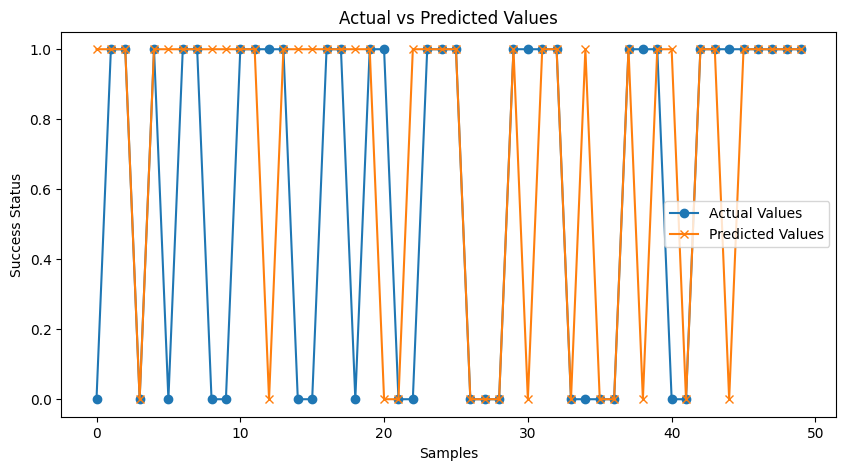

In [30]:
# Comparison Chart
plt.figure(figsize=(10, 5))
plt.plot(predictions_pd["success"][:50], label="Actual Values", marker="o")
plt.plot(predictions_pd["prediction"][:50], label="Predicted Values", marker="x")
plt.title("Actual vs Predicted Values")
plt.xlabel("Samples")
plt.ylabel("Success Status")
plt.legend()
plt.show()